# Imports

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import IPython.display as pyDisplay
import matplotlib.transforms as transforms 
import scipy.special as sciSpec
import subprocess
import tfs

from cpymad.madx import Madx
import Backend.Constants as cst
import Backend.WCTools as WCTools
import Backend.MADXTools as MADXTools

#import xline as xl
#import xobjects as xo
#import xtrack as xt
#import xpart as xp

# Utilities

In [3]:
def plotKick(x,y,DPx,DPy,title='',ax=None,**kwargs):
    if ax is None:
        ax = plt.gca()
    plt.title(title,fontsize=25)
    arrowLength = 0.5*np.max(np.diff(np.sort(x/1e-3)))

    for _x,_y,_DPx,_DPy in zip(x,y,DPx,DPy):
        thisNorm = WCTools.vecNorm([ _DPx,_DPy])
        plt.arrow(_x/1e-3, _y/1e-3, _DPx/thisNorm*arrowLength, _DPy/thisNorm*arrowLength,head_width=0.1, head_length=0.1)

    plt.scatter(x/1e-3,y/1e-3,c=WCTools.vecNorm([DPx,DPy]),zorder=len(x)+1,**kwargs)
    cbar = plt.colorbar()
    cbar.set_label('Kick',fontsize=20)
    plt.xlabel('x [mm]',fontsize=20)
    plt.ylabel('y [mm]',fontsize=20)
    plt.axis('square')
    
    
def importTRK(filename):
    with open(filename, "r+") as f:
        content = f.readlines()
        f.seek(0)
        for line in content:
            if '#segment' not in line:
                f.write(line)
        f.truncate()

    tracked = tfs.read(filename)
    tracked.columns = tracked.columns.str.lower()
    
    return tracked

def importTwiss(filename):
    twiss = tfs.read(filename)
    twiss.columns = list(twiss.columns.str.lower())
    twiss.name = twiss.name.str.lower()
    twiss.keyword = twiss.keyword.str.lower()
    
    return twiss

def PLOTFODO(twiss,title=''):
    # Plotting beta function
    #---------------------------    
    
    plt.title(title,loc='left')
    axLeft = plt.gca()
    h1, = plt.plot(twiss['s'],twiss['betx'],'b-',label=r'$\beta_x$')
    h2, = plt.plot(twiss['s'],twiss['bety'],'r-',label=r'$\beta_y$')
    plt.ylabel(r'$\beta$ [m]')

    axRight = plt.twinx()
    h3, = plt.plot(twiss['s'],twiss['dx'],'g-',label=r'$D_x$')
    h4, = plt.plot(twiss['s'],twiss['dy'],'y-',label=r'$D_y$')
    plt.legend(handles=[h1,h2,h3,h4],ncol=4,loc='upper center', bbox_to_anchor=(0.5, 1.12))
    plt.ylabel(r'$D$ [m]')

    plt.xlabel('s [m]')


    # Adding Quad strength
    #--------------------------- 
    axOff = axLeft.twinx()
    plt.plot(twiss['s'],0*twiss['s'],'k')
    MADXTools.plotElements(twiss,ax=axOff)
    axOff.axis('off')
    #plt.ylim([-0.01,0.01])

# B-Field and expected Kick

/home/pbelange/WC_Comparison/Backend/WCTools.py:218: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(currentNorm, extent = currentExtent,origin='lower',norm=norm,vmin=colorLim[0], vmax=colorLim[1])


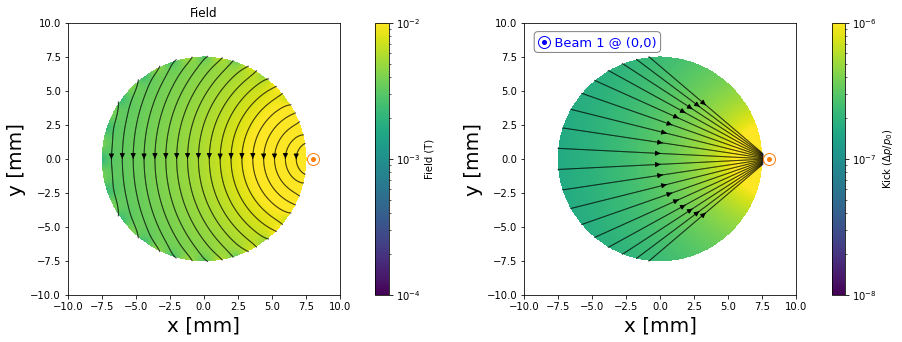

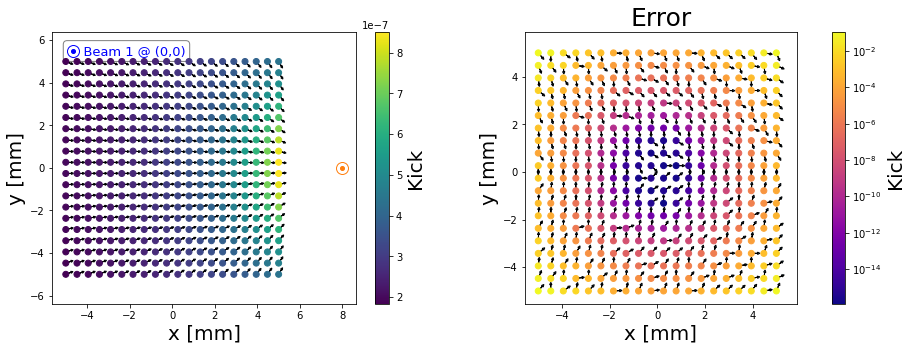

In [6]:

Energy = 7000e9
rightWire = WCTools.wire(x=8e-3,y=0e-3,I=230,L=1.3)

xVec = np.linspace(-10e-3,10e-3,1000)
xObs,yObs = np.meshgrid(xVec,xVec)

Bx,By = 0*xObs,0*xObs
for thisWire in [rightWire]:
    _Bx,_By = rightWire.getField(xObs,yObs,order=20)
    Bx += _Bx
    By += _By


fig,axes = plt.subplots(1,2,figsize=(15,5))
plt.sca(axes[0])
plt.title('Field')
WCTools.plotVecField(xObs,yObs,Bx,By,scaling=1e3,colorLabel='Field (T)',mode='streamplot',rValid=0.95*rightWire.r0,seedAngle=rightWire.theta0,nSeeds=20,colorLim = [1e-4,1e-2],norm = 'log')
for thisWire in [rightWire]:
    thisWire.plotWireLocation(scaling=1e3)
plt.axis('square')
plt.xlabel('x [mm]',fontsize=20)
plt.ylabel('y [mm]',fontsize=20)


xVec = np.linspace(-10e-3,10e-3,1000)
xObs,yObs = np.meshgrid(xVec,xVec)
Px,Py = 0*xObs,0*xObs

for thisWire in [rightWire]:
    _Px,_Py = thisWire.getKick(xObs,yObs,Energy,order=np.inf)
    Px += _Px
    Py += _Py

    
plt.sca(axes[1])
WCTools.plotVecField(xObs,yObs,Px,Py,scaling=1e3,colorLabel=r'Kick ($\Delta p/p_0$)',mode='streamplot',rValid=0.95*rightWire.r0,seedAngle=np.pi/2,nSeeds=20,colorLim = [1e-8,1e-6],norm='log')
for thisWire in [rightWire]:
    thisWire.plotWireLocation(scaling=1e3)

WCTools.plotBeamDirection(0.05,0.93,name= 'Beam 1 @ (0,0)',color = 'b',direction = '+',fontsize = 13,ax = None)
plt.axis('square')
plt.xlabel('x [mm]',fontsize=20)
plt.ylabel('y [mm]',fontsize=20)





x,y = np.meshgrid(np.linspace(-5e-3,5e-3,20),np.linspace(-5e-3,5e-3,20))
x,y = x.flatten(),y.flatten()

Px_multi,Py_multi = 0*x,0*x
for thisWire in [rightWire]:
    _Px,_Py = thisWire.getKick(x,y,Energy,order=20)
    Px_multi += _Px
    Py_multi += _Py

Px,Py = 0*x,0*x
for thisWire in [rightWire]:
    _Px,_Py = thisWire.getKick(x,y,Energy,order=np.inf)
    Px += _Px
    Py += _Py

fig,axes = plt.subplots(1,2,figsize=(15,5))
plt.sca(axes[0])
cmap = plt.cm.viridis
plotKick(x,y,Px,Py,ax=axes[0],cmap=cmap)
thisWire.plotWireLocation(scaling=1e3,ax=axes[0])
plt.xlim([-9,9])
plt.axis('equal')
WCTools.plotBeamDirection(0.05,0.93,name= 'Beam 1 @ (0,0)',color = 'b',direction = '+',fontsize = 13,ax = None)
    
plt.sca(axes[1])
cmap = plt.cm.plasma
Errx,Erry = np.abs(Px-Px_multi)/Px,np.abs(Py-Py_multi)/Py
plotKick(x,y,Errx,Erry,title='Error',ax=axes[1],cmap=cmap,norm=LogNorm())

# MAD-X implementation

## Tobias Persson implementation

`label: WIRE,  CURRENT={real, ... }, L=real,L_INT={real, ... }, L_PHY={real,...};`


The $\texttt{WIRE}$ element allows to define one or several wire elements at once. 

- $\texttt{L}$ The length of the element in the sequence.
- $\texttt{CURRENT}$ The current for the wires. 
- $\texttt{L_PHY}$ This should correspond to the actuall physical length of the wires. 
- $\texttt{L_INT}$ The length where we stop integrating the effect of the field.
   It needs to be larger or the same as $\texttt{L_PHY}$.
- $\texttt{XMA}$ This specifies the horizontal offset of the wire compared to the reference orbit. 
- $\texttt{YMA}$ This specifies the vertical offset of the wire compared to the reference orbit. 


The WIRE as implemented in MAD-X is imlemented as a thin kick. However, it is still 
possible to define a length of the wire but internally the element is 
placed in the middle and drift spaces are placed on each side of the $\texttt{WIRE}$.
Note also that the collimator element has the same attiributes as the $\texttt{WIRE}$
and by defining it using the same parameters you can also get the collimator with a wire
inside. 


# Kick ($\Delta p/p_0$)

mode                 name  at  \
0  install  wire_multipole_1of2   1   
1  install  wire_multipole_2of2   1   

                                          definition  
0  class_wire_multipole_1of2 : MULTIPOLE,KNL = {0...  
1  class_wire_multipole_2of2 : KICKER, L=0, HKICK...

mode     name  at                                         definition
0  install  wire_bb   1  class_wire_bb : beambeam, charge = -6766315813...

mode         name  at                                         definition
0  install  wire_tobias   1  class_wire_tobias : wire,current = 250,L = 00,...

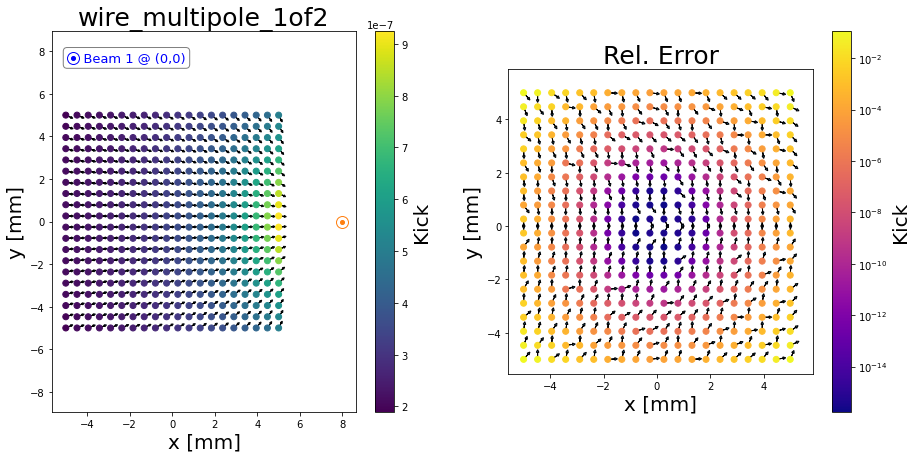

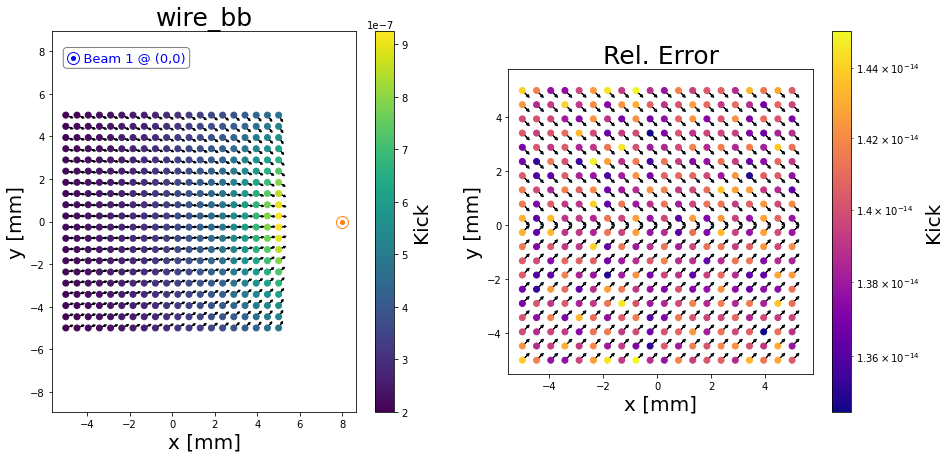

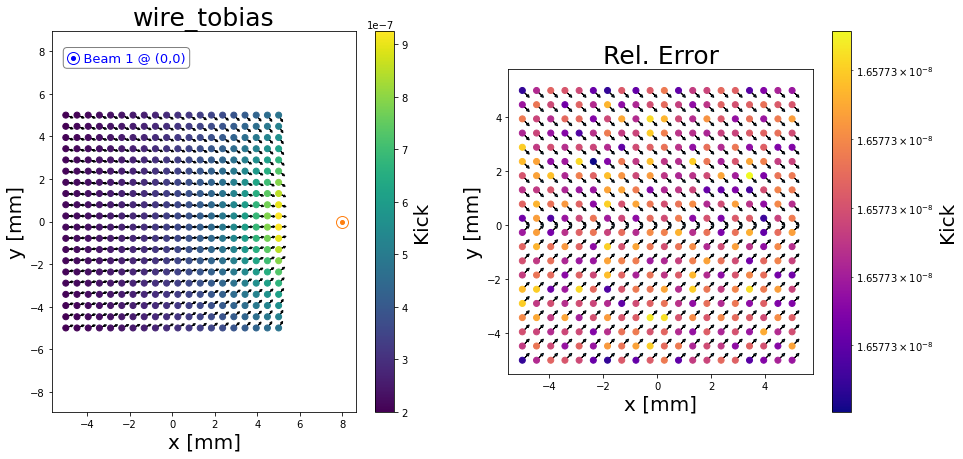

In [4]:

# Defining MAD-X parameters
#===========================
madDict = { 'name' : 'singlekick',
            'L_seq' : 1,
            'Energy' : 7000e9}


# Defining all the wire elements to study
#======================================
wire_multipole = WCTools.wire(x=8e-3,y=0,I=250,L=1.3,madClass='multipole')
wire_bb        = WCTools.wire(x=8e-3,y=0,I=250,L=1.3,madClass='bb')
wire_tobias    = WCTools.wire(x=8e-3,y=0,I=250,L=1.3,madClass='tobias')

atLocation = 1
BBORBIT = True
installationDF = [wire_multipole.toMad(at=atLocation,Energy=madDict['Energy'],name='wire_multipole',order=20,BBORBIT = BBORBIT),
                  wire_bb.toMad(at=atLocation,Energy=madDict['Energy'],name='wire_bb'),
                  wire_tobias.toMad(at=atLocation,name='wire_tobias')]


# Correcting installationDF for no-fringe fields;
tmp_wire = installationDF[2].copy()
tmp_wire.loc[0,'definition'] = tmp_wire.loc[0,'definition'].replace('L_phy = ','L_phy = 1000000*')
tmp_wire.loc[0,'definition'] = tmp_wire.loc[0,'definition'].replace('L = ','L = 0')
installationDF[2] = tmp_wire

wireList = [wire_multipole,wire_bb,wire_tobias]

# Defining coordinates for tracking
#======================================
x,y = np.meshgrid(np.linspace(-5e-3,5e-3,20),np.linspace(-5e-3,5e-3,20))
x,y = x.flatten(),y.flatten()
coordinates = pd.DataFrame({'x':x,'y':y,'px':np.zeros(len(x)),'py':np.zeros(len(y))})


# Looping
#=======================================
for toInstall,thisWire in zip(installationDF,wireList):
  
    # Starting MAD-X
    madFile = "tmp_my_log.mad"
    mad = Madx(command_log = madFile)
    mad.option(echo = True, warn = True)
    mad.input(f'option, bborbit={BBORBIT}')
    mad.input(MADXTools.madSetup.format(**madDict))

    # Installing wire
    display(toInstall)
    mad.input(MADXTools.seqedit(sequence = madDict['name'],editing = toInstall))

    # Writing tracking commands
    trkFile = 'trackingresults.trk'
    MADXTools.MADTrackParticles(mad,coordinates,saveFile=trkFile)

    # Re-oppening tracking file
    tracked = mad.table['trackone'].dframe()
    
    # Extracting Tracking results
    x,y = np.array(tracked.groupby('turn').get_group(0)['x']),np.array(tracked.groupby('turn').get_group(0)['y'])
    DPx = np.array(tracked.groupby('turn').get_group(1)['px'])-np.array(tracked.groupby('turn').get_group(0)['px'])
    DPy = np.array(tracked.groupby('turn').get_group(1)['py'])-np.array(tracked.groupby('turn').get_group(0)['py'])

    
    fig,axes = plt.subplots(1,2,figsize=(15,7))
    plt.sca(axes[0])
    cmap = plt.cm.viridis
    plotKick(x,y,DPx,DPy,title=toInstall.iloc[0]['name'],ax=axes[0],cmap=cmap)
    thisWire.plotWireLocation(scaling=1e3,ax=axes[0])
    plt.xlim([-9,9])
    plt.axis('equal')
    WCTools.plotBeamDirection(0.05,0.93,name= 'Beam 1 @ (0,0)',color = 'b',direction = '+',fontsize = 13,ax = None)
    
    plt.sca(axes[1])
    cmap = plt.cm.plasma
    DPx_inf,DPy_inf = thisWire.getKick(x,y,Energy=madDict['Energy'],order=np.inf)
    Errx,Erry = np.abs(DPx_inf-DPx)/DPx_inf,np.abs(DPy_inf-DPy)/DPy_inf
    #Errx,Erry = np.abs(DPx_inf-DPx),np.abs(DPy_inf-DPy)
    plotKick(x,y,Errx,Erry,title='Rel. Error',ax=axes[1],cmap=cmap,norm=LogNorm())
    
    plt.savefig(toInstall.iloc[0]['name']+'_kick.png',dpi=300)
    

In [69]:
mad.elements.class_wire_tobias

class_wire_tobias: wire, at=1.0, l=0.0, xma={0.008}, yma={0.0}, current={250.0}, l_int={1.3}, l_phy={1300000.0};

In [70]:
tmp_wire.loc[0,'definition']

'class_wire_tobias : wire,current = 250,L = 0,L_phy = 1000000*1.3,L_int = 1.3,Xma = 0.008,Yma = 0;'

# 2nd+ order kick

mode            name  at  \
0  install  wire_multipole   1   

                                          definition  
0  class_wire_multipole_1of2 : MULTIPOLE,KNL = {0...

mode     name  at                                         definition
0  install  wire_bb   1  class_wire_bb : beambeam, charge = -6225010548...

mode         name  at                                         definition
0  install  wire_tobias   1  class_wire_tobias : wire,current = 230,L = 0,L...

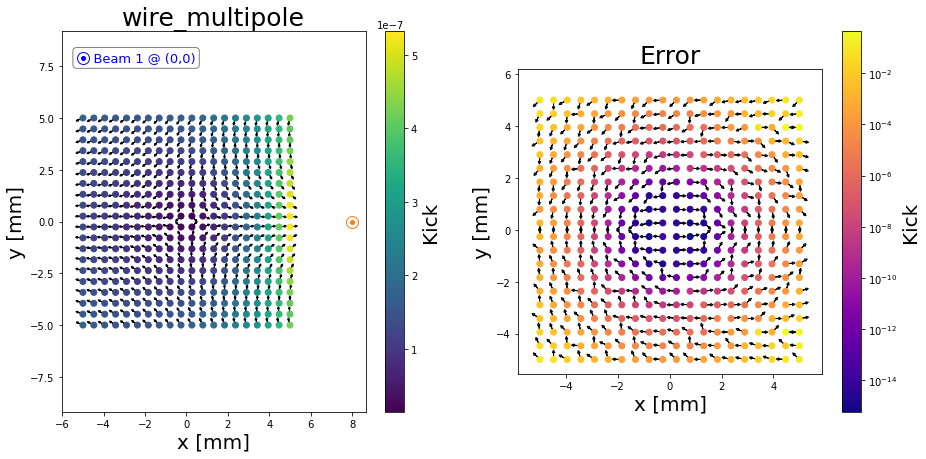

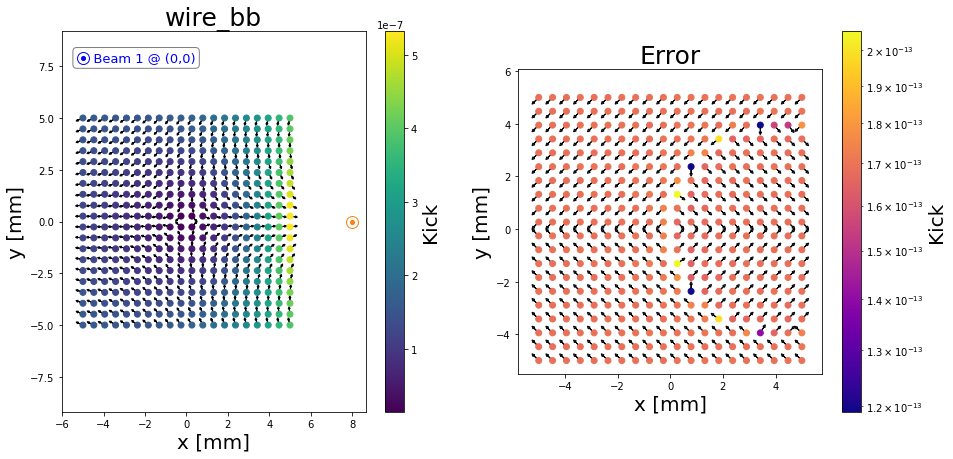

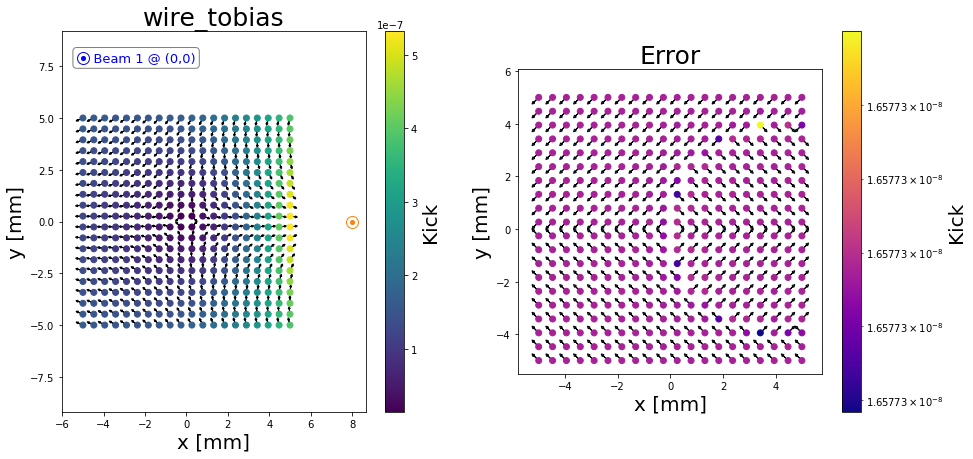

In [58]:

# Defining MAD-X parameters
#===========================
madDict = { 'name' : 'singlekick',
            'L_seq' : 1,
            'Energy' : 7000e9}


# Defining all the wire elements to study
#======================================
wire_multipole = WCTools.wire(x=8e-3,y=0e-3,I=230,L=1.3,madClass='multipole')
wire_bb        = WCTools.wire(x=8e-3,y=0e-3,I=230,L=1.3,madClass='bb')
wire_tobias    = WCTools.wire(x=8e-3,y=0e-3,I=230,L=1.3,madClass='tobias')

atLocation = 1
BBORBIT = False
installationDF = [wire_multipole.toMad(at=atLocation,Energy=madDict['Energy'],name='wire_multipole',order=20,BBORBIT = BBORBIT),
                  wire_bb.toMad(at=atLocation,Energy=madDict['Energy'],name='wire_bb'),
                  wire_tobias.toMad(at=atLocation,name='wire_tobias')]

# Correcting installationDF for no-fringe fields;
tmp_wire = installationDF[2].copy()
tmp_wire.loc[0,'definition'] = tmp_wire.loc[0,'definition'].replace('L_phy = ','L_phy = 1000000*')
installationDF[2] = tmp_wire

wireList = [wire_multipole,wire_bb,wire_tobias]

onepassList = ['onepass','','onepass']

# Defining coordinates for tracking
#======================================
x,y = np.meshgrid(np.linspace(-5e-3,5e-3,20),np.linspace(-5e-3,5e-3,20))
x,y = x.flatten(),y.flatten()
coordinates = pd.DataFrame({'x':x,'y':y,'px':np.zeros(len(x)),'py':np.zeros(len(y))})


# Looping
#=======================================
for toInstall,thisWire,onepass in zip(installationDF,wireList,onepassList):
  
    # Starting MAD-X
    madFile = "tmp_my_log.mad"
    mad = Madx(command_log = madFile)
    mad.option(echo = True, warn = True)
    mad.input(f'option, bborbit={BBORBIT}')
    mad.input(MADXTools.madSetup.format(**madDict))

    # Installing wire
    display(toInstall)
    mad.input(MADXTools.seqedit(sequence = madDict['name'],editing = toInstall))

    # Writing tracking commands
    trkFile = 'trackingresults.trk'
    MADXTools.MADTrackParticles(mad,coordinates,saveFile=trkFile,onepass = onepass)
    mad.input('twiss,betx=1,bety=1,alfx=0,alfy=0;')
    
    # Re-oppening tracking file
    tracked = mad.table['trackone'].dframe()
    twiss = mad.table['twiss'].dframe()
    
    # Extracting Tracking results
    x,y = np.array(tracked.groupby('turn').get_group(0)['x']),np.array(tracked.groupby('turn').get_group(0)['y'])
    DPx = np.array(tracked.groupby('turn').get_group(1)['px'])-np.array(tracked.groupby('turn').get_group(0)['px'])
    DPy = np.array(tracked.groupby('turn').get_group(1)['py'])-np.array(tracked.groupby('turn').get_group(0)['py'])

    
    fig,axes = plt.subplots(1,2,figsize=(15,7))
    plt.sca(axes[0])
    cmap = plt.cm.viridis
    plotKick(x,y,DPx,DPy,title=toInstall.iloc[0]['name'],ax=axes[0],cmap=cmap)
    thisWire.plotWireLocation(scaling=1e3,ax=axes[0])
    plt.xlim([-9,9])
    plt.axis('equal')
    WCTools.plotBeamDirection(0.05,0.93,name= 'Beam 1 @ (0,0)',color = 'b',direction = '+',fontsize = 13,ax = None)
    
    plt.sca(axes[1])
    cmap = plt.cm.plasma
    
    DPx_inf,DPy_inf = thisWire.getKick(x,y,Energy=madDict['Energy'],order=np.inf)
    _DPx_corrector,_DPy_corrector = thisWire.getKick(x,y,Energy=madDict['Energy'],order=0)
    DPx_inf -= _DPx_corrector
    DPy_inf -= _DPy_corrector
    
    Errx,Erry = np.abs(DPx_inf-DPx)/DPx_inf,np.abs(DPy_inf-DPy)/DPy_inf
    plotKick(x,y,Errx,Erry,title='Error',ax=axes[1],cmap=cmap,norm=LogNorm())
    
    

In [41]:
twiss['x']

#s             0.0
drift_0[0]     0.0
wire_tobias    0.0
#e             0.0
Name: x, dtype: float64

In [44]:
Px,Py = thisWire.getKick(0,1e-3,Energy=madDict['Energy'],order=50)
_Px,_Py = thisWire.getKick(0,1e-3,Energy=madDict['Energy'],order=0)
print(Px-_Px,Py-_Py,(_Px,_Py))

-4.925161854243793e-09 -3.940129483395007e-08 (array(3.20135521e-07), -0.0)


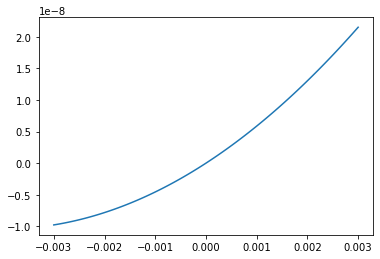

In [77]:
xVec = np.linspace(-3e-3,3e-3,100)
Px,Py = thisWire.getKick(xVec,0,Energy=madDict['Energy'],order=2)
_Px,_Py = thisWire.getKick(0,1e-3,Energy=madDict['Energy'],order=0)
plt.figure()
plt.plot(xVec,Px-_Px)

In [51]:
xVec

array([-5.00000000e-05,  1.01010101e-06,  5.20202020e-05,  1.03030303e-04,
        1.54040404e-04,  2.05050505e-04,  2.56060606e-04,  3.07070707e-04,
        3.58080808e-04,  4.09090909e-04,  4.60101010e-04,  5.11111111e-04,
        5.62121212e-04,  6.13131313e-04,  6.64141414e-04,  7.15151515e-04,
        7.66161616e-04,  8.17171717e-04,  8.68181818e-04,  9.19191919e-04,
        9.70202020e-04,  1.02121212e-03,  1.07222222e-03,  1.12323232e-03,
        1.17424242e-03,  1.22525253e-03,  1.27626263e-03,  1.32727273e-03,
        1.37828283e-03,  1.42929293e-03,  1.48030303e-03,  1.53131313e-03,
        1.58232323e-03,  1.63333333e-03,  1.68434343e-03,  1.73535354e-03,
        1.78636364e-03,  1.83737374e-03,  1.88838384e-03,  1.93939394e-03,
        1.99040404e-03,  2.04141414e-03,  2.09242424e-03,  2.14343434e-03,
        2.19444444e-03,  2.24545455e-03,  2.29646465e-03,  2.34747475e-03,
        2.39848485e-03,  2.44949495e-03,  2.50050505e-03,  2.55151515e-03,
        2.60252525e-03,  

# Closed Orbit

name         x        betx      alfx
wire_multipole_2of2  wire_multipole_2of2:1  0.000044  157.521833  1.641089
wire_multipole_1of2  wire_multipole_1of2:1  0.000044  157.521833  1.634716

name         x        betx      alfx
wire_bb  wire_bb:1  0.000044  157.521833  1.634716

name         x        betx      alfx
wire_tobias  wire_tobias:1  0.000044  157.521808  1.634716

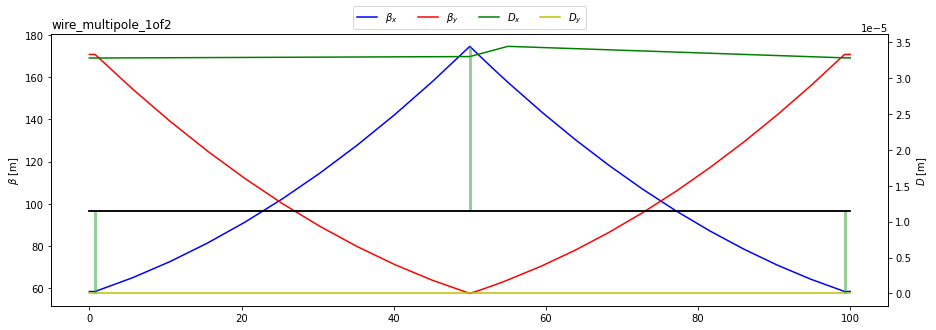

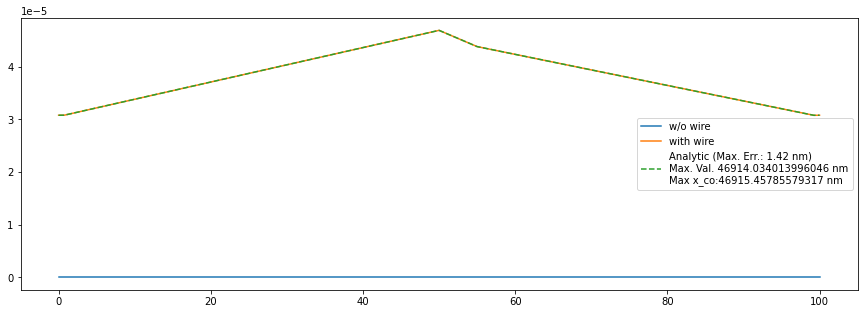

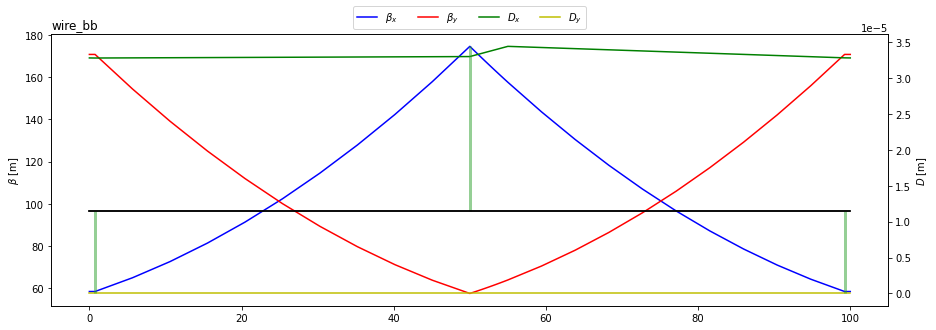

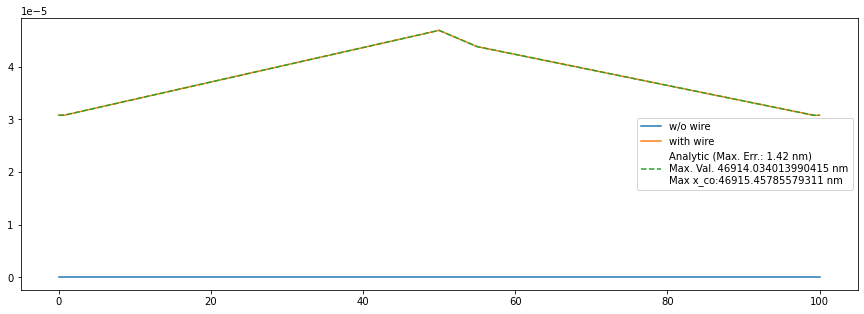

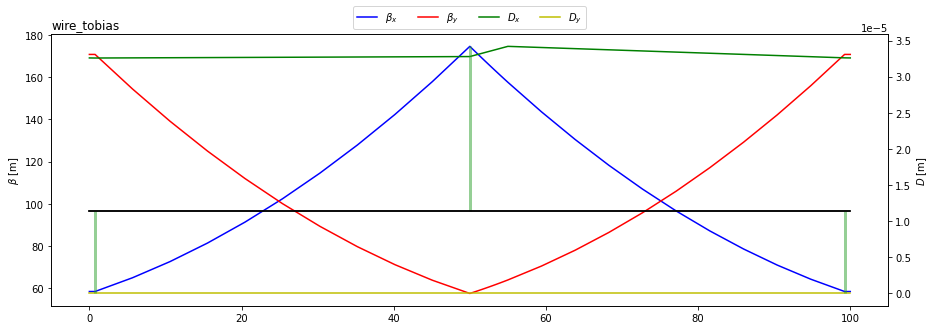

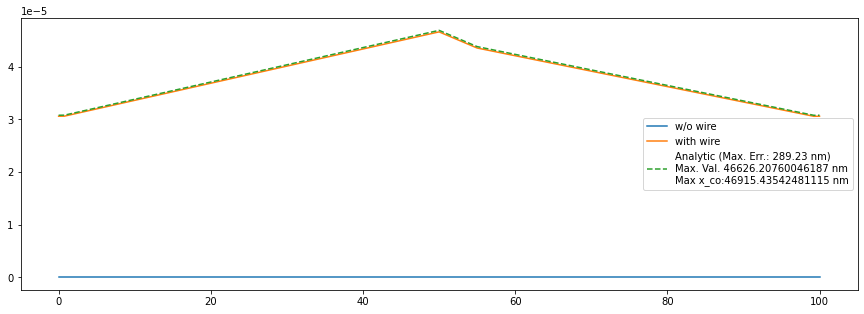

In [34]:

# Defining MAD-X parameters
#===========================
madDict = { 'name': 'FODO',
                'L_seq' : 100,
                'L_Q' : 3,
                'K_Q' : 1/(100/2)/3,
                'Energy' : 7000e9,
                'mux':1/6,
                'muy':1/6}


# Defining FODO Structure
#===========================
FODOcomponents = pd.DataFrame({'mode':['install','install','install'],
                             'name':['Q1','Q2','Q3'],
                             'at': [madDict['L_Q']/4,
                                    madDict['L_seq']/2,
                                    madDict['L_seq']-madDict['L_Q']/4],
                             'definition':[f'Qd : quadrupole,l={madDict["L_Q"]/2},k1:=K_Qd;',
                                           f'Qf : quadrupole,l={madDict["L_Q"]},k1:=K_Qf;',
                                           f'Qd : quadrupole,l={madDict["L_Q"]/2},k1:=K_Qd;']})


# Defining all the wire elements to study
#======================================
BBORBIT = True
wire_multipole = WCTools.wire(x=8e-3,y=0,I=230,L=1.3,madClass='multipole')
wire_bb        = WCTools.wire(x=8e-3,y=0,I=230,L=1.3,madClass='bb')
wire_tobias    = WCTools.wire(x=8e-3,y=0,I=230,L=1.3,madClass='tobias')

atLocation = 55
installationDF = [wire_multipole.toMad(at=atLocation,Energy=madDict['Energy'],name='wire_multipole',order=20,BBORBIT = BBORBIT),
                  wire_bb.toMad(at=atLocation,Energy=madDict['Energy'],name='wire_bb'),
                  wire_tobias.toMad(at=atLocation,name='wire_tobias')]

wireList = [wire_multipole,wire_bb,wire_tobias]

# Defining coordinates for tracking
#======================================
x,y = np.meshgrid(np.linspace(-5e-3,5e-3,20),np.linspace(-5e-3,5e-3,20))
x,y = x.flatten(),y.flatten()
coordinates = pd.DataFrame({'x':x,'y':y,'px':np.zeros(len(x)),'py':np.zeros(len(y))})

# Looping
#=======================================
for toInstall,thisWire in zip(installationDF,wireList):
  
    # Starting MAD-X
    madFile = "tmp_my_log.mad"
    mad = Madx(command_log = madFile)    
    mad.option(echo = True, warn = True)
    mad.input(f'option, bborbit={BBORBIT}')
    
    # Defining quad strength for matching and finishing setup
    mad.input(""" K_Qf = {K_Q}; K_Qd = -{K_Q};""".format(**madDict))
    mad.input(MADXTools.madSetup.format(**madDict))

    # Installing FODO structure:
    mad.input(MADXTools.seqedit(sequence = madDict['name'],editing = FODOcomponents,makeThin=True))
    
    # Adding markers along the line and matching
    refTwiss_file = 'ref_twiss'
    #mad.input('select,flag=interpolate,step=0.1;')
    mad.input('select,flag=interpolate,slice=10;')
    
    # MATCHING
    mad.input(MADXTools.madMatch.format(**madDict))
    mad.input(f'twiss,table={refTwiss_file};')
    
    # Installing wire 
    finalTwiss_file = 'final_twiss'
    mad.input(MADXTools.seqedit(sequence = madDict['name'],editing = toInstall,makeThin=True))
    mad.input(f'twiss,table={finalTwiss_file};')
    
    
    # Importing twiss
    refTwiss = mad.table[refTwiss_file].dframe()
    twiss = mad.table[finalTwiss_file].dframe()
    
    #twiss = mad.table['twiss'].dframe()
    plane = 'x'
    display(twiss[twiss['name'].str.contains('wire')][['name',f'{plane}',f'bet{plane}',f'alf{plane}']])
    
    
    # Computing analytic closed orbit change
    twiss_wire = twiss.set_index('name').loc[toInstall.iloc[0]['name']+':1']
    DPx_inf,DPy_inf = thisWire.getKick(0,0,Energy=madDict['Energy'],order=np.inf)
   
    DP = {'x':DPx_inf,'y':DPy_inf}
    Q_x = twiss.iloc[-1][f'mu{plane}']
    J_x = twiss_wire[f'bet{plane}']*DP[plane]**2/(8*np.sin(np.pi*Q_x)**2)
    x_co = np.sqrt(2*twiss[f'bet{plane}']*J_x)*np.cos(2*np.pi*(np.abs(twiss[f'mu{plane}']-twiss_wire[f'mu{plane}'])) - np.pi*Q_x)
    
    plt.figure(figsize=(15,5))
    PLOTFODO(twiss,title = toInstall.iloc[0]['name'])
    
    plt.figure(figsize=(15,5))
    plt.plot(refTwiss['s'],refTwiss[f'{plane}'],label='w/o wire')
    plt.plot(twiss['s'],twiss[f'{plane}'],label='with wire')
    #plt.plot(twiss['s'],x_co,'--',label=f'Analytic (Max. Rel. Err.: {np.max(np.abs(x_co-twiss[f"{plane}"])/np.abs(x_co)):.3e})')
    plt.plot(twiss['s'],x_co,'--',label=f'Analytic (Max. Err.: {np.max(np.abs(x_co-twiss[f"{plane}"]))/1e-9:.2f} nm)\nMax. Val. {np.max(twiss[f"{plane}"])/1e-9} nm\nMax x_co:{np.max(x_co)/1e-9} nm')
    
    #plt.plot(twiss['s'],x_co/twiss["x"]-1)
    
    plt.legend()
    
#plt.figure()
#plt.plot()

In [31]:
np.max(x_co)

4.691543542481115e-05

In [27]:
mad.globals.keys()


KeysView({'none': 0.0, 'twiss_tol': 1e-06, 'k_qf': 0.0067050887772386126, 'k_qd': -0.0067298160261869844, 'tar': 2.722861432277227e-09})

In [28]:
mad.globals['k_qf']

0.0067050887772386126

In [15]:
installationDF[0].iloc[0].definition

'class_wire_multipole_1of2 : MULTIPOLE,KNL = {0,4.0016940065730545e-05,-0.0,-3.751588131162238,0.0,1172371.2909881996,-0.0,-769368659711.0061,0.0,8.655397421748817e+17,-0.0,-1.487646431863078e+24,0.0,3.626138177666252e+30,-0.0,-1.1898265895467394e+37,0.0,5.056763005573642e+43,-0.0,-2.702207731103414e+50,0.0},KSL = {0,-0.0,-0.010004235016432633,0.0,1875.7940655811187,-0.0,-879278468.2411494,0.0,769368659711006.1,-0.0,-1.081924677718602e+21,0.0,2.2314696477946168e+27,-0.0,-6.345741810915941e+33,0.0,2.3796531790934785e+40,-0.0,-1.1377716762540691e+47,0.0,6.7555193277585365e+53};'

In [16]:

installationDF[0].iloc[1].definition

'class_wire_multipole_2of2 : KICKER, L=0, HKICK=-0.0, VKICK=3.2013552052584436e-07, TILT=real;'

# Tune shift

In [75]:
import shutil
from tqdm.notebook import tqdm
# Defining MAD-X parameters
#===========================
madDict = { 'name': 'FODO',
                'L_seq' : 100,
                'L_Q' : 3,
                'K_Q' : 1/(100/2)/3,
                'Energy' : 7000e9,
                'mux':1/6,
                'muy':1/6}

atLocation = 55

# Defining FODO Structure
#===========================
FODOcomponents = pd.DataFrame({'mode':['install','install','install','install'],
                             'name':['Q1','Q2','Q3','WC_marker'],
                             'at': [madDict['L_Q']/4,
                                    madDict['L_seq']/2,
                                    madDict['L_seq']-madDict['L_Q']/4,
                                    atLocation],
                             'definition':[f'Qd : quadrupole,l={madDict["L_Q"]/2},k1:=K_Qd;',
                                           f'Qf : quadrupole,l={madDict["L_Q"]},k1:=K_Qf;',
                                           f'Qd : quadrupole,l={madDict["L_Q"]/2},k1:=K_Qd;',
                                           f'wire_marker : marker;']})


# Loop parameters
#======================================
BBORBIT = False
wireTypes = ['multipole','bb','tobias']
I_list = [130,230,330]
rw_list = np.linspace(3e-3,15e-3,20)
L_w = 1.3
tuneShift = {'Conditions':[],'D_mux':[],'D_muy':[],'betx':[],'bety':[]}

# Looping
#=======================================
for wireType in tqdm(wireTypes):

    for I in I_list:
        D_mux = []
        D_muy = []
        for rw in rw_list:

            thisWire = WCTools.wire(x=rw,y=0,I=I,L=L_w,madClass=wireType)
            
            if wireType == 'multipole':
                toInstall = thisWire.toMad(at=atLocation,Energy=madDict['Energy'],name=f'wire_{wireType}',order=20,BBORBIT=BBORBIT)
            else:
                toInstall = thisWire.toMad(at=atLocation,Energy=madDict['Energy'],name=f'wire_{wireType}')

            # Starting MAD-X
            madFile = "tmp_my_log.mad"
            mad = Madx(command_log = madFile)    
            mad.option(echo = True, warn = True)
            mad.input(f'option, bborbit={BBORBIT}')

            # Defining quad strength for matching and finishing setup
            mad.input(""" K_Qf = {K_Q}; K_Qd = -{K_Q};""".format(**madDict))
            mad.input(MADXTools.madSetup.format(**madDict))

            # Installing FODO structure:
            mad.input(MADXTools.seqedit(sequence = madDict['name'],editing = FODOcomponents,makeThin=True))

            # MATCHING
            refTwiss_file = 'ref_twiss'
            mad.input(MADXTools.madMatch.format(**madDict))
            mad.input(f'twiss,table={refTwiss_file},file={refTwiss_file};')

            # Installing wire 
            finalTwiss_file = 'final_twiss'
            mad.input(MADXTools.seqedit(sequence = madDict['name'],editing = toInstall,makeThin=True))
            mad.input(f'twiss,table={finalTwiss_file},file={finalTwiss_file};')

            # Importing twiss
            refTwiss = mad.table[refTwiss_file].dframe()#importTwiss(refTwiss_file)
            twiss = mad.table[finalTwiss_file].dframe()#importTwiss(finalTwiss_file)


            D_mux.append(twiss.iloc[-1]['mux'] - refTwiss.iloc[-1]['mux'] )
            D_muy.append(twiss.iloc[-1]['muy'] - refTwiss.iloc[-1]['muy'] )
                
        tuneShift['Conditions'].append((wireType,I))
        tuneShift['D_mux'].append(D_mux)
        tuneShift['D_muy'].append(D_muy)
        tuneShift['betx'].append(refTwiss.set_index('name').loc['wc_marker:1']['betx'])
        tuneShift['bety'].append(refTwiss.set_index('name').loc['wc_marker:1']['bety'])

tuneShiftResults = pd.DataFrame(tuneShift)
tuneShiftResults.set_index('Conditions',inplace=True)
display(tuneShiftResults)

  0%|          | 0/3 [00:00<?, ?it/s]

D_mux  \
Conditions                                                            
(multipole, 130)  [-0.0020199109684325423, -0.001376795281025050...   
(multipole, 230)  [-0.0035841008958211185, -0.002440654900365463...   
(multipole, 330)  [-0.00515769032538585, -0.0035087838648973635,...   
(bb, 130)         [-0.0020199109684324867, -0.001376795281025078...   
(bb, 230)         [-0.0035841008958206466, -0.00244065490036513,...   
(bb, 330)         [-0.005157690325385655, -0.003508783864897169,...   
(tobias, 130)     [-0.0020199055935450905, -0.001376789911475384...   
(tobias, 230)     [-0.0035840913300659027, -0.00244064536263483,...   
(tobias, 330)     [-0.005157676516960807, -0.0035087701248802394...   

                                                              D_muy  \
Conditions                                                            
(multipole, 130)  [0.0008180204909241373, 0.0005584944756444332,...   
(multipole, 230)  [0.0014456372223279612, 0.000987342659357321, ...   
(multipole, 330)  [0.0020718578866423254, 0.0014155341868916649,...   
(bb, 130)         [0.0008180204909241096, 0.0005584944756444332,...   
(bb, 230)         [0.0014456372223277392, 0.0009873426593572099,...   
(bb, 330)         [0.0020718578866422144, 0.0014155341868916094,...   
(tobias, 130)     [0.0008161377056247754, 0.0005569380589498796,...   
(tobias, 230)     [0.0014423135842139279, 0.0009845932261037804,...   
(tobias, 330)     [0.002067099723774779, 0.0014115953565442263, ...   

                        betx       bety  
Conditions                               
(multipole, 130)  157.231515  64.005781  
(multipole, 230)  157.231515  64.005781  
(multipole, 330)  157.231515  64.005781  
(bb, 130)         157.231515  64.005781  
(bb, 230)         157.231515  64.005781  
(bb, 330)         157.231515  64.005781  
(tobias, 130)     157.231515  64.005781  
(tobias, 230)     157.231515  64.005781  
(tobias, 330)     157.231515  64.005781

# Plotting

$$\Delta Q_x = -\frac{\beta_x(s_w)}{B\rho}\frac{\mu_0 (IL)}{8\pi^2 r_w^2}$$

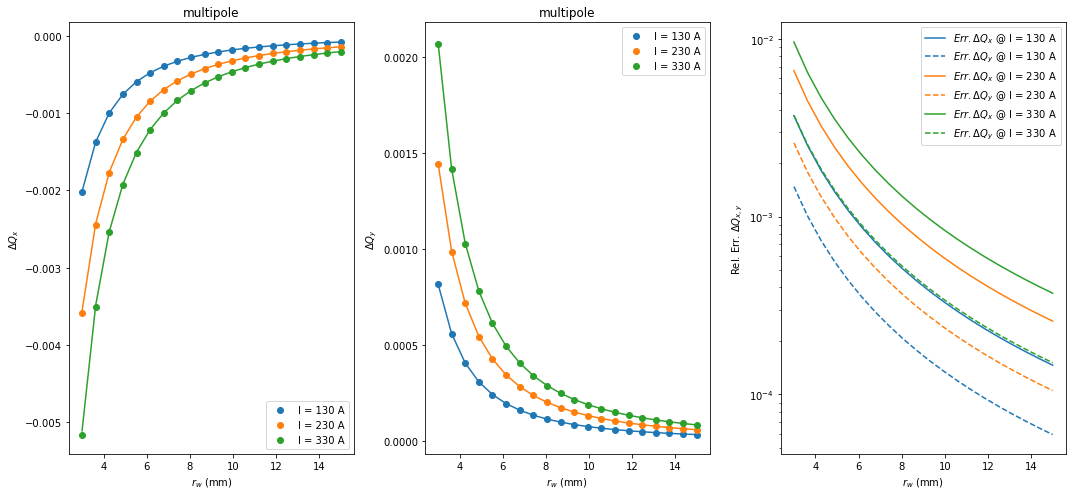

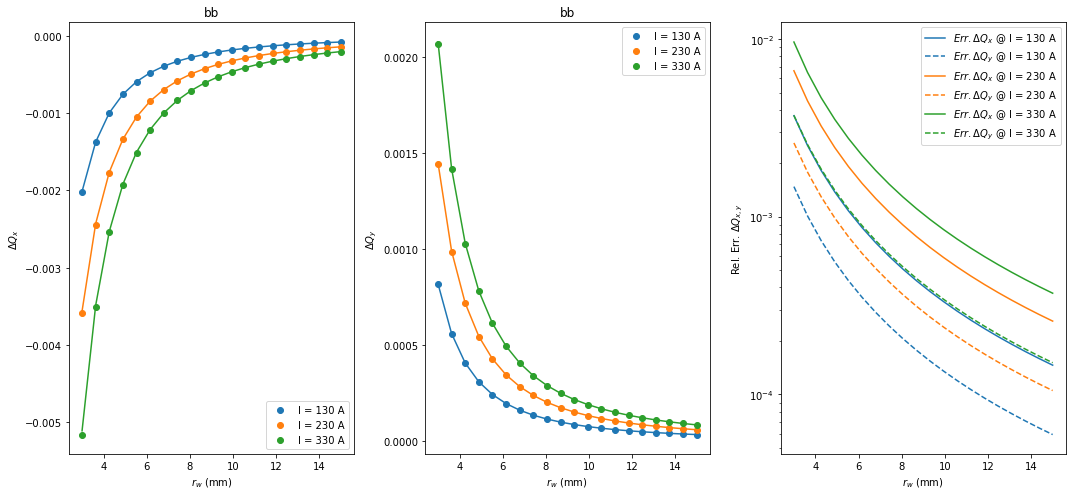

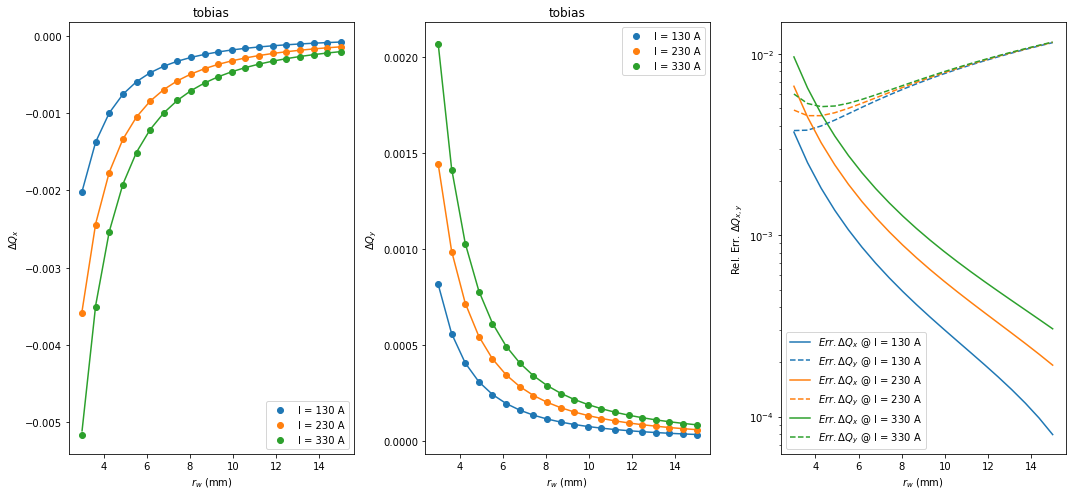

In [76]:
def getTuneShift(I,L,rw,beta,Energy):
    p0 = np.sqrt(Energy**2-cst.m_p_eV**2)/cst.c
    DQ = -beta*cst.mu0*I*L/(p0*8*(np.pi**2)*(rw**2))
    return DQ
    
for wireType in wireTypes:
    fig,axes = plt.subplots(1,3,figsize=(15,7))
    
    for I,color in zip(I_list,['C0','C1','C2']):
        thisCurve = tuneShiftResults.loc[[(wireType,I)]].reset_index().iloc[0]
        thisCurve[f'bety'] *= -1
        for plane,ax in zip(['x','y'],[axes[0],axes[1]]):
            plt.sca(ax)
            plt.title(wireType)
            DQ_ref = (getTuneShift(I,L_w,rw_list,beta=thisCurve[f'bet{plane}'],Energy=madDict['Energy']))
            DQ = (np.array(thisCurve[f'D_mu{plane}']))
            
            # NORMALIZED BY BETA:
            #DQ_ref = (getTuneShift(I,L_w,rw_list,beta=1,Energy=madDict['Energy']))
            #DQ = (np.array(thisCurve[f'D_mu{plane}'])/thisCurve[f'bet{plane}'])
            
            h = plt.plot(rw_list/1e-3,DQ,'o',label = f'I = {I} A')
            plt.plot(rw_list/1e-3,DQ_ref,'-',color=h[0].get_color())
            plt.ylabel(rf'$\Delta Q_{plane}$')
            plt.legend()
            plt.xlabel(r'$r_w$ (mm)')
            
            
            plt.sca(axes[2])
            style = {'x':'-','y':'--'}
            plt.plot(rw_list/1e-3, np.abs(DQ_ref-DQ)/np.abs(DQ_ref),style[plane],color=color,label = rf'$Err. \Delta Q_{plane}$ @ I = {I} A')
            plt.yscale('log')
            plt.ylabel('Rel. Err. $\Delta Q_{x,y}$')
            plt.legend()
            plt.xlabel(r'$r_w$ (mm)')
            
    plt.tight_layout()
    plt.savefig('test.pdf',format='pdf')
    plt.savefig('test.png',format='png')

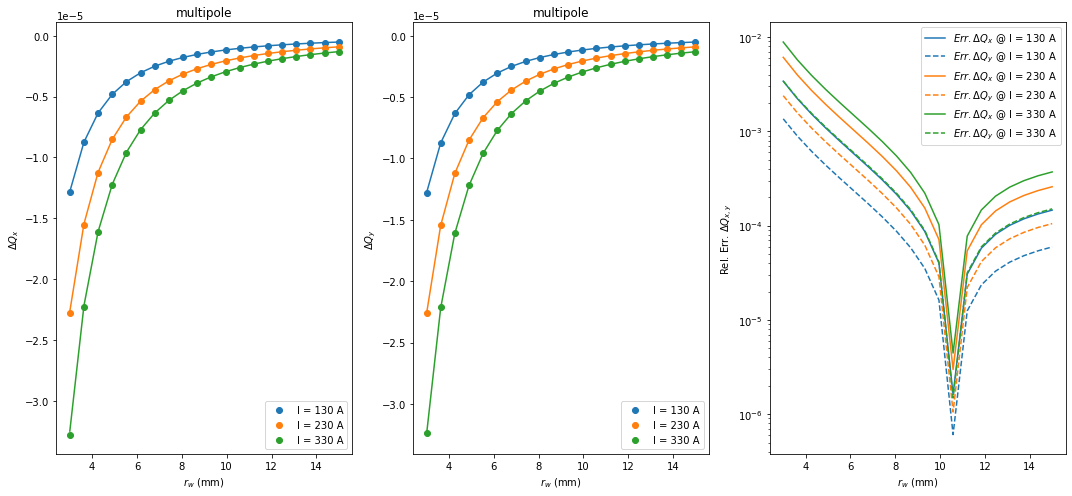

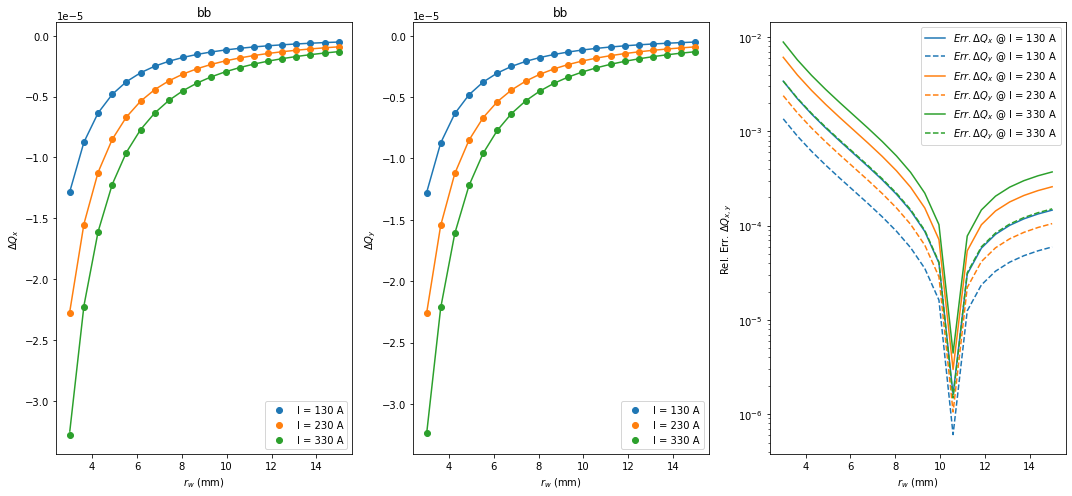

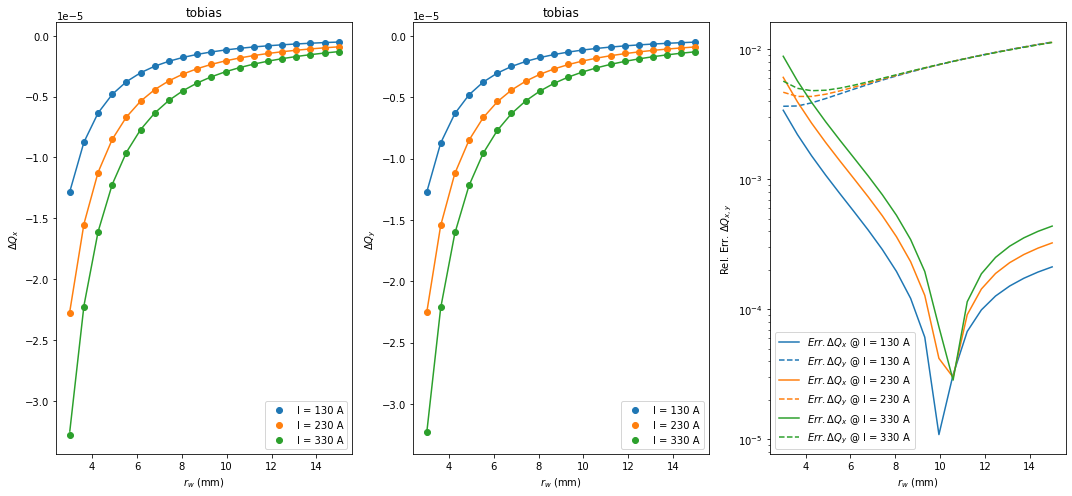

In [18]:
def getTuneShift(I,L,rw,beta,Energy):
    p0 = np.sqrt(Energy**2-cst.m_p_eV**2)/cst.c
    DQ = -beta*cst.mu0*I*L/(p0*8*(np.pi**2)*(rw**2))
    return DQ
    
for wireType in wireTypes:
    fig,axes = plt.subplots(1,3,figsize=(15,7))
    
    for I,color in zip(I_list,['C0','C1','C2']):
        thisCurve = tuneShiftResults.loc[[(wireType,I)]].reset_index().iloc[0]
        thisCurve[f'bety'] *= -1
        for plane,ax in zip(['x','y'],[axes[0],axes[1]]):
            plt.sca(ax)
            plt.title(wireType)
            #DQ_ref = (getTuneShift(I,L_w,rw_list,beta=thisCurve[f'bet{plane}'],Energy=madDict['Energy']))
            #DQ = (np.array(thisCurve[f'D_mu{plane}']))
            
            # NORMALIZED BY BETA:
            DQ_ref = (getTuneShift(I,L_w,rw_list,beta=1,Energy=madDict['Energy']))
            DQ = (np.array(thisCurve[f'D_mu{plane}'])/thisCurve[f'bet{plane}'])
            
            h = plt.plot(rw_list/1e-3,DQ,'o',label = f'I = {I} A')
            plt.plot(rw_list/1e-3,DQ_ref,'-',color=h[0].get_color())
            plt.ylabel(rf'$\Delta Q_{plane}$')
            plt.legend()
            plt.xlabel(r'$r_w$ (mm)')
            
            
            plt.sca(axes[2])
            style = {'x':'-','y':'--'}
            plt.plot(rw_list/1e-3, np.abs(DQ_ref-DQ)/np.abs(DQ_ref),style[plane],color=color,label = rf'$Err. \Delta Q_{plane}$ @ I = {I} A')
            plt.yscale('log')
            plt.ylabel('Rel. Err. $\Delta Q_{x,y}$')
            plt.legend()
            plt.xlabel(r'$r_w$ (mm)')
            
    plt.tight_layout()
    plt.savefig('test.pdf',format='pdf')
    plt.savefig('test.png',format='png')

In [ ]:
twiss

#s             0.0
drift_0[0]     0.0
q1             0.0
drift_1[0]     0.0
q2             0.0
drift_2[0]     0.0
wire_tobias    0.0
wc_marker      0.0
drift_3[0]     0.0
q3             0.0
drift_4[0]     0.0
#e             0.0
Name: y, dtype: float64